In [149]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
from sklearn import preprocessing


In [150]:
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('Date', axis=1)
    data = data.drop('Adj Close', axis=1)
    data = data.drop(0, axis=0)
    data=data.dropna(axis=0)

    data = data.values
#     print(data.shape)

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    #print(data_normalised.shape)
   
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        
        sma = np.mean(his[:, 3])
        
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))
   
    technical_indicators = np.array(technical_indicators)
    print(technical_indicators.shape)
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [166]:
history_points=50
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('INFY.NS1.csv')
print(ohlcv_histories.shape)
print(technical_indicators.shape)
print(next_day_open_values.shape)
print(unscaled_y.shape)


(6306, 1)
(6306, 50, 5)
(6306, 1)
(6306, 1)
(6306, 1)


In [167]:
test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)
print(ohlcv_histories[0].shape)
ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

(50, 5)


In [168]:
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mean_squared_error')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=30, shuffle=True, validation_split=0.1)

Epoch 1/30
160/160 [==============================] - 10s 65ms/step - loss: 0.0081 - val_loss: 1.8173e-04
Epoch 2/30
160/160 [==============================] - 9s 58ms/step - loss: 2.6723e-04 - val_loss: 2.7059e-04
Epoch 3/30
160/160 [==============================] - 10s 64ms/step - loss: 1.7889e-04 - val_loss: 1.1823e-04
Epoch 4/30
160/160 [==============================] - 9s 57ms/step - loss: 1.5962e-04 - val_loss: 1.3014e-04
Epoch 5/30
160/160 [==============================] - 10s 60ms/step - loss: 1.5843e-04 - val_loss: 9.4412e-05
Epoch 6/30
160/160 [==============================] - 9s 55ms/step - loss: 1.3321e-04 - val_loss: 9.1666e-05
Epoch 7/30
160/160 [==============================] - 9s 56ms/step - loss: 1.2967e-04 - val_loss: 8.6672e-05
Epoch 8/30
160/160 [==============================] - 9s 54ms/step - loss: 1.2230e-04 - val_loss: 3.2313e-04
Epoch 9/30
160/160 [==============================] - 8s 47ms/step - loss: 1.2100e-04 - val_loss: 1.0947e-04
Epoch 10/30
160/160 

In [169]:

print(model.summary())

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 50, 5)]           0         
_________________________________________________________________
lstm_0 (LSTM)                (None, 50)                11200     
_________________________________________________________________
lstm_dropout_0 (Dropout)     (None, 50)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                3264      
_________________________________________________________________
sigmoid_0 (Activation)       (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
linear_output (Activation)   (None, 1)               

(631, 50, 5)
75.39684060817764


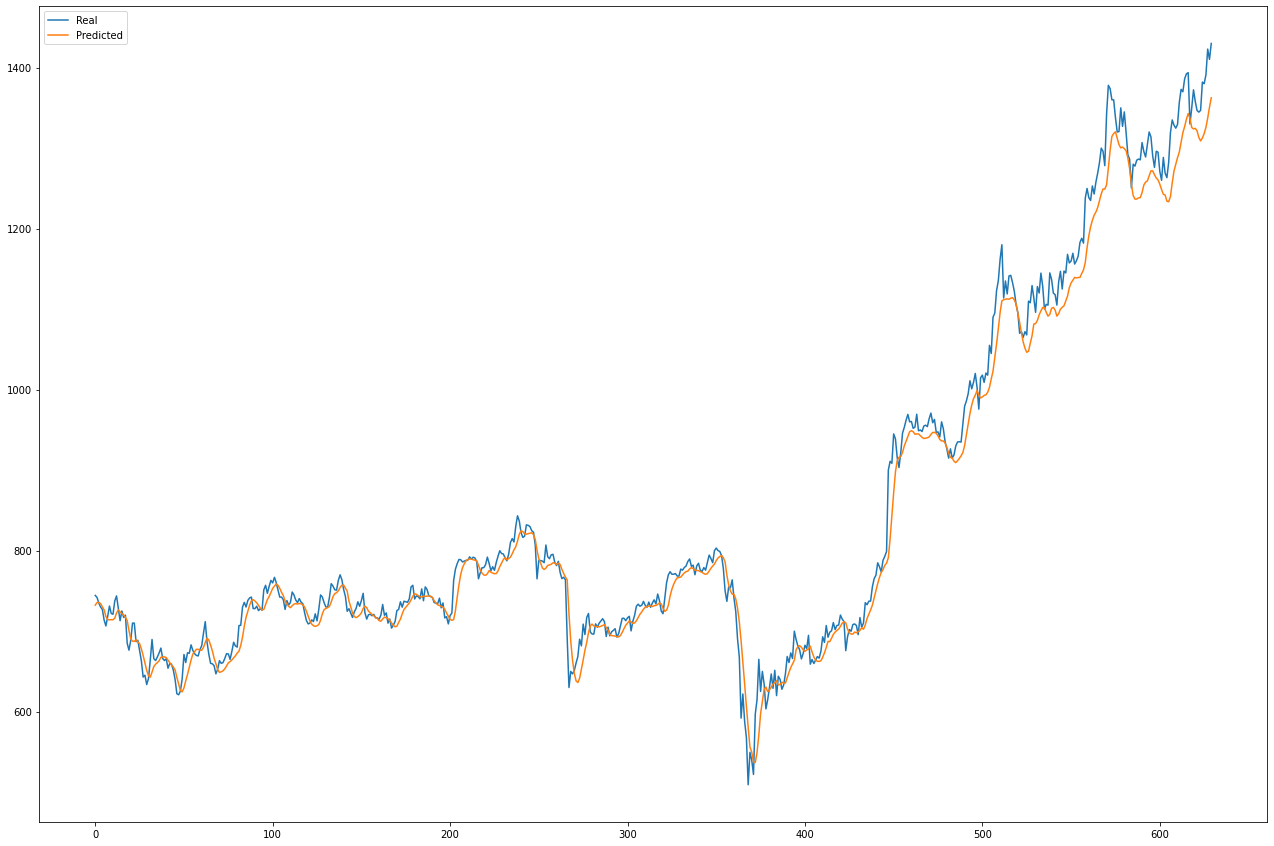

In [170]:
print(ohlcv_test.shape)
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()



In [156]:
print(unscaled_y_test)
print(y_test_predicted)

[[1373.      ]
 [1370.      ]
 [1386.050049]
 [1392.25    ]
 [1393.75    ]
 [1330.      ]
 [1350.099976]
 [1372.449951]
 [1357.849976]
 [1346.75    ]
 [1344.699951]
 [1346.900024]
 [1382.      ]
 [1380.      ]
 [1391.      ]
 [1423.      ]
 [1410.25    ]
 [1430.      ]
 [1455.      ]
 [1474.      ]]
[[1140.0652]
 [1140.0681]
 [1140.1494]
 [1140.1761]
 [1140.251 ]
 [1140.1399]
 [1139.4539]
 [1139.8035]
 [1139.933 ]
 [1139.9706]
 [1139.7256]
 [1139.94  ]
 [1139.6615]
 [1139.8696]
 [1140.0854]
 [1140.0404]
 [1140.436 ]
 [1140.5168]
 [1140.731 ]
 [1140.9298]]
